In [3]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
from statsmodels.tsa.stattools import adfuller,acf,pacf
from statsmodels.tsa.arima.model import ARIMA
import math
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=15,6

import warnings
warnings.filterwarnings('ignore')

In [4]:
data=pd.read_csv('C:\\Users\\hp\\Documents\\DATA SCIENCE\\data_sets\\Demo Datasets\\Lesson 8\\AirPassengers.csv')

In [5]:
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [6]:
#we filter the month from date using the lambda function
data['Month']=data['Month'].apply(lambda x:dt(int(x[:4]), int(x[5:]),15))

In [7]:
#set month to index
data=data.set_index('Month')

In [8]:
data.head()

,#Passengers
Month,
1949-01-15,112
1949-02-15,118
1949-03-15,132
1949-04-15,129
1949-05-15,121


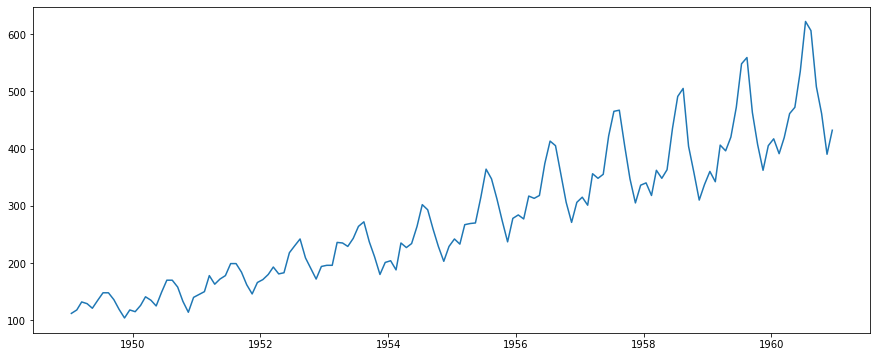

In [9]:
#we plot the passengers data time series
ts=data['#Passengers']
plt.plot(ts)

In [10]:
#the data is observed to have a nonconstant mean nonstationarity type
#we transform the series for stationarity using log decomposition
ts_log=np.log(ts)

In [16]:
#we perform stationarity check using the rolling statistics and dicky fuller test
def test_stationarity(timeseries):
    rolmean=timeseries.rolling(window=52, center=False).mean()
    rolstd=timeseries.rolling(window=52,center=False).std()
    
    #plot the rolling statistics
    orig=plt.plot(timeseries, color='blue', label='original')
    mean=plt.plot(rolmean, color='red', label='Rollong mean')
    std=plt.plot(rolstd, color='black', label='Rolling std')
    plt.legend(loc='best')
    plt.title('Rolling mean $ standard deviation')
    plt.show(block=False)
    
    
    print('Result of Dicky Fuller test: ')
    dftest=adfuller(timeseries, autolag='AIC') #initializing the dicky_fuller test
    dfoutput=pd.Series(dftest[0:4],index=['test statistics', 'p_value', '#lags used', 'Number of observations used'])
    
    for key,value in dftest[4].items():    #initializing the critical values
        dfoutput['Critical value (%s)' %key]=value
    print(dfoutput)
    

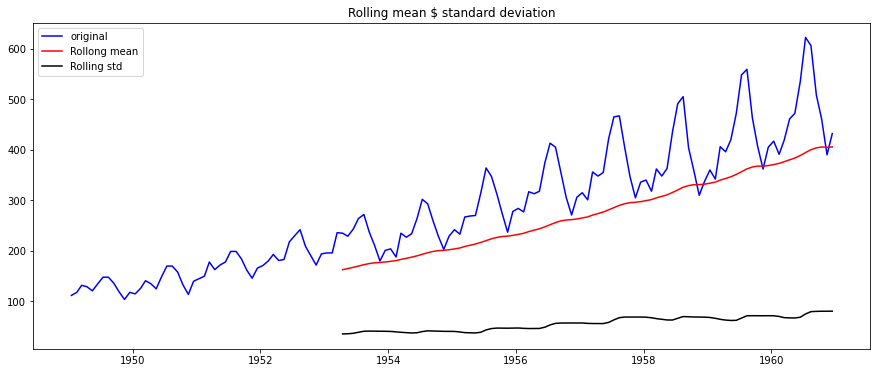

Result of Dicky Fuller test: 
test statistics                  0.815369
p_value                          0.991880
#lags used                      13.000000
Number of observations used    130.000000
Critical value (1%)             -3.481682
Critical value (5%)             -2.884042
Critical value (10%)            -2.578770
dtype: float64


In [17]:
test_stationarity(data['#Passengers'])

In [18]:
#we observe that the test statistic is greater than the critical valuse and the moving averages is not constant over time.
#The null hypothesis cannot be rejected. Conclusion: The data is not stationary

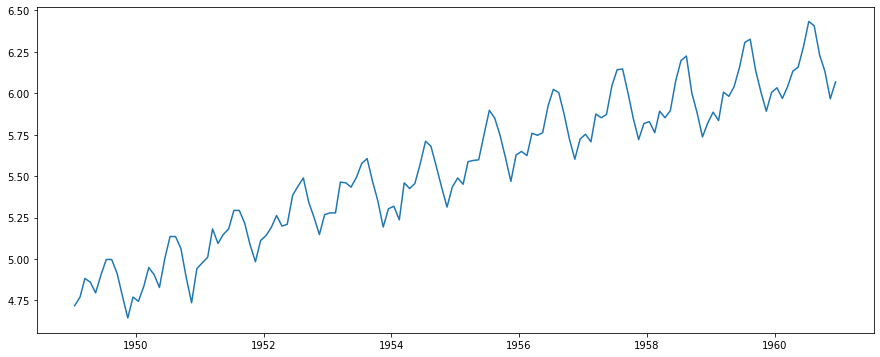

In [19]:
#we decompose the data
ts_log=np.log(ts)
plt.plot(ts_log)

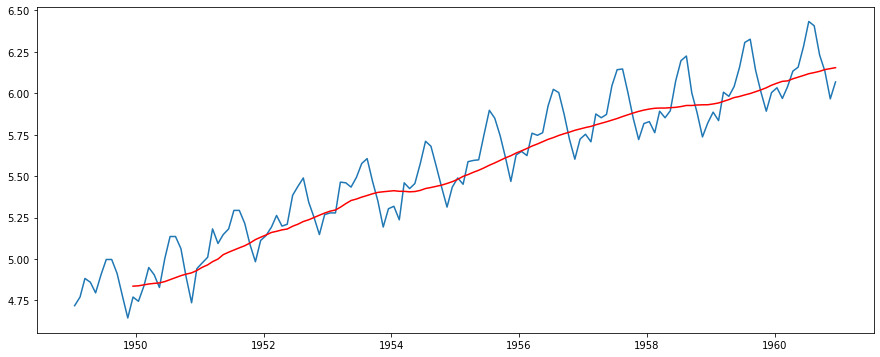

In [20]:
#we initialize the moving average variable
moving_ave=ts_log.rolling(window=12).mean()
moving_std=ts_log.rolling(window=12).std()

plt.plot(ts_log)
plt.plot(moving_ave, color='red')


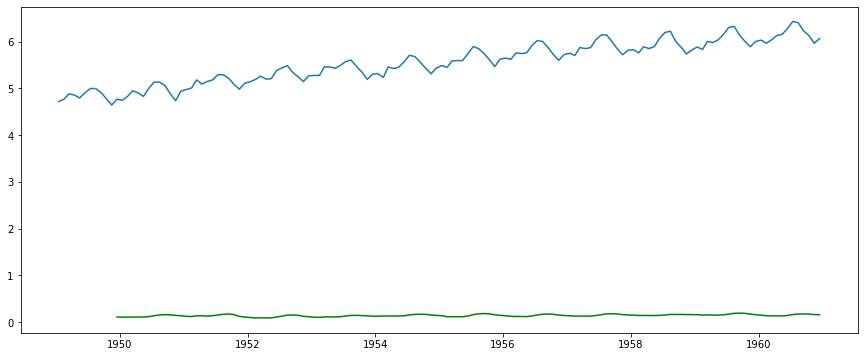

In [21]:
plt.plot(ts_log)
plt.plot(moving_std, color='green')

In [22]:
#we plot the ts_log moving difference
ts_log_mv_diff=ts_log-moving_ave
ts_log_mv_diff.head(12)

Month
1949-01-15         NaN
1949-02-15         NaN
1949-03-15         NaN
1949-04-15         NaN
1949-05-15         NaN
1949-06-15         NaN
1949-07-15         NaN
1949-08-15         NaN
1949-09-15         NaN
1949-10-15         NaN
1949-11-15         NaN
1949-12-15   -0.065494
Name: #Passengers, dtype: float64

In [23]:
ts_log_mv_diff.isna().sum()

11

In [24]:
#we drop the nan values
ts_log_mv_diff.dropna(inplace=True)
ts_log_mv_diff.head(12)

Month
1949-12-15   -0.065494
1950-01-15   -0.093449
1950-02-15   -0.007566
1950-03-15    0.099416
1950-04-15    0.052142
1950-05-15   -0.027529
1950-06-15    0.139881
1950-07-15    0.260184
1950-08-15    0.248635
1950-09-15    0.162937
1950-10-15   -0.018578
1950-11-15   -0.180379
Name: #Passengers, dtype: float64

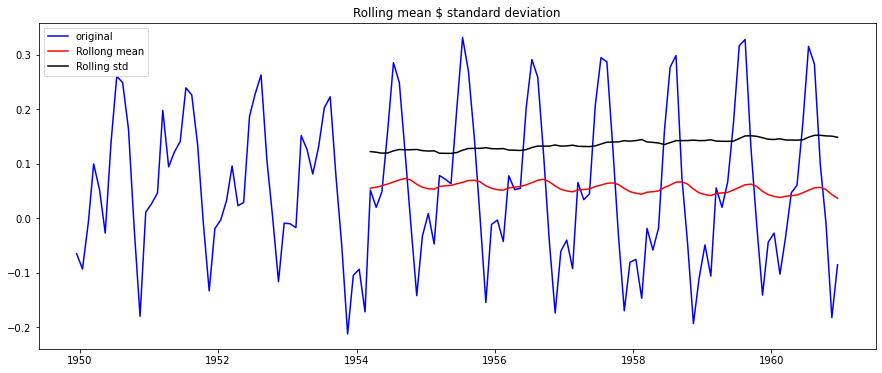

Result of Dicky Fuller test: 
test statistics                 -3.162908
p_value                          0.022235
#lags used                      13.000000
Number of observations used    119.000000
Critical value (1%)             -3.486535
Critical value (5%)             -2.886151
Critical value (10%)            -2.579896
dtype: float64


In [25]:
#we check for stationarity again
test_stationarity(ts_log_mv_diff)

In [26]:
#the dicky fuller test implies that the test statistics is less than 1% of the critical value.
#This implies that the data is 99% stationary, hence we reject the null hypothesis
#H0: TS is Nonstationary vs H1: Ts is stationary
#Reject H0 if test statistic(ts) < critical value.

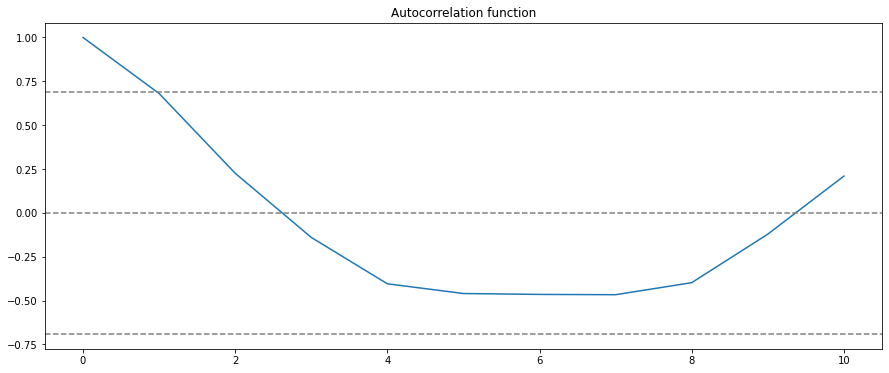

In [30]:
#we plot the ACF curve(autocorrelation function curve)
plt.plot(np.arange(0,11), acf(ts_log_mv_diff,nlags=10))
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--', color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--', color='gray')
plt.title('Autocorrelation function')
plt.show()

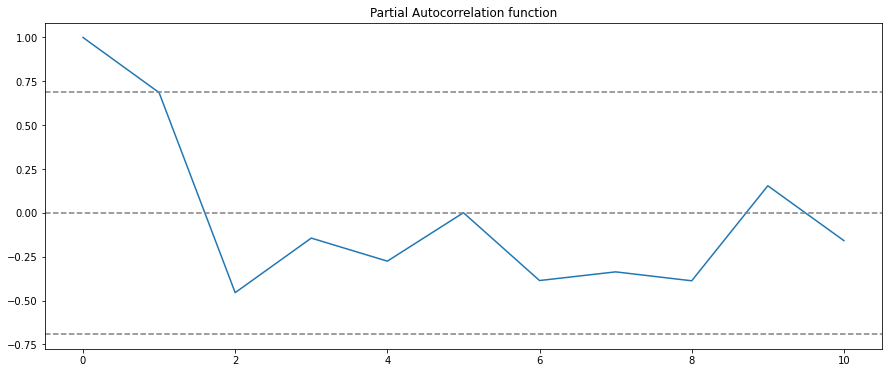

In [32]:
#we plot the PACF curve(autocorrelation function curve)
plt.plot(np.arange(0,11), pacf(ts_log_mv_diff,nlags=10))
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--', color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--', color='gray')
plt.title('Partial Autocorrelation function')
plt.show()

Text(0.5, 1.0, 'RSS:nan')

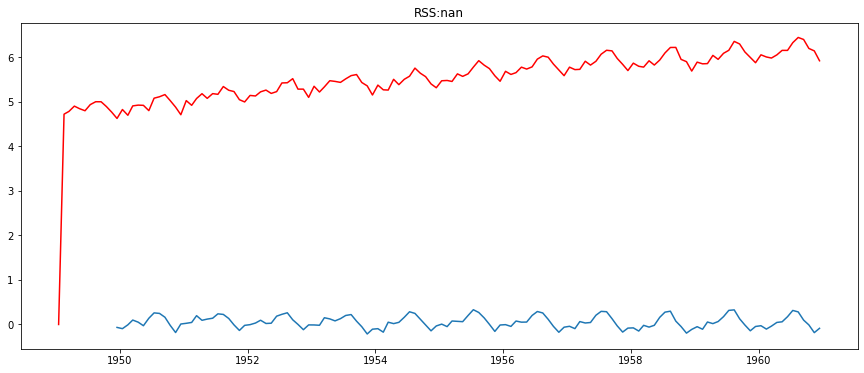

In [83]:
#we initialize the ARIMA model
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')
model=ARIMA(ts_log,order=(1,1,0),validate_specification=True)
result_arima2=model.fit()
plt.plot(ts_log_mv_diff)
plt.plot(result_arima.fittedvalues, color='red')
plt.title('RSS:%.4f'%sum((result2_arima.fittedvalues[1:] - ts_log_mv_diff)**2))

In [40]:
result_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 120.299
Date:                Thu, 29 Sep 2022   AIC                           -236.598
Time:                        06:17:15   BIC                           -230.672
Sample:                             0   HQIC                          -234.190
                                - 144                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2054      0.093      2.203      0.028       0.023       0.388
sigma2         0.0109      0.002      6.050      0.000       0.007       0.014
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                 6.19
Prob(Q):                              0.71   Prob(JB):                         0.05
Heteroskedasticity (H):               1.16   Skew:                             0.19
Prob(H) (two-sided):                  0.60   Kurtosis:                         2.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Text(0.5, 1.0, 'RSS:nan')

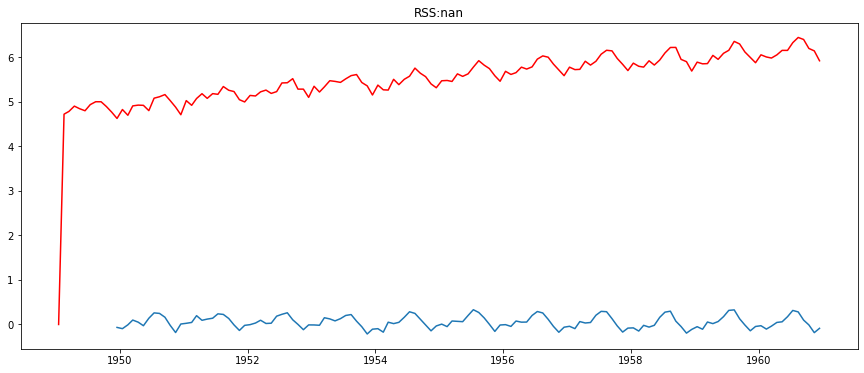

In [50]:
#we initialize the ARIMA model
from statsmodels.tsa.arima.model import ARIMA
model=ARIMA(ts_log,order=(1,1,1))
result_arima=model.fit()
plt.plot(ts_log_mv_diff)
plt.plot(result_arima.fittedvalues, color='red')
plt.title('RSS:%.4f'%sum((result_arima.fittedvalues[1:]-ts_log_mv_diff)**2))

In [51]:
result_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 124.313
Date:                Thu, 29 Sep 2022   AIC                           -242.626
Time:                        06:27:00   BIC                           -233.738
Sample:                             0   HQIC                          -239.014
                                - 144                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5773      0.164     -3.517      0.000      -0.899      -0.256
ma.L1          0.8478      0.098      8.687      0.000       0.657       1.039
sigma2         0.0103      0.002      5.992      0.000       0.007       0.014
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 5.94
Prob(Q):                              0.90   Prob(JB):                         0.05
Heteroskedasticity (H):               1.07   Skew:                             0.04
Prob(H) (two-sided):                  0.82   Kurtosis:                         2.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [53]:
#model prediction
from statsmodels.tsa.arima.model import ARIMA
model=ARIMA(ts_log,order=(1,1,0))
result2_arima=model.fit()
predict_ARIMA_diff=pd.Series(result2_arima.fittedvalues,copy=True)

In [54]:
predict_ARIMA_diff.head()

Month
1949-01-15    0.000000
1949-02-15    4.718499
1949-03-15    4.781404
1949-04-15    4.905832
1949-05-15    4.855090
dtype: float64

In [55]:
#we find the cummulative sum of the predicted values
predict_ARIMA_diff_cumsum=predict_ARIMA_diff.cumsum()

In [56]:
predict_ARIMA_diff_cumsum.head()

Month
1949-01-15     0.000000
1949-02-15     4.718499
1949-03-15     9.499903
1949-04-15    14.405735
1949-05-15    19.260825
dtype: float64

In [57]:
#we create a new series and set ts_log to index
predict_ARIMA_log=pd.Series(ts_log.iloc[0], index=ts_log.index)
#we add the predict_ARIMA_diff_cumsum into the series
predict_ARIMA_log=predict_ARIMA_log.add(predict_ARIMA_diff_cumsum,fill_value=0)

In [58]:
predict_ARIMA_log.head()

Month
1949-01-15     4.718499
1949-02-15     9.436998
1949-03-15    14.218402
1949-04-15    19.124234
1949-05-15    23.979324
dtype: float64

Text(0.5, 1.0, 'RMSE: inf')

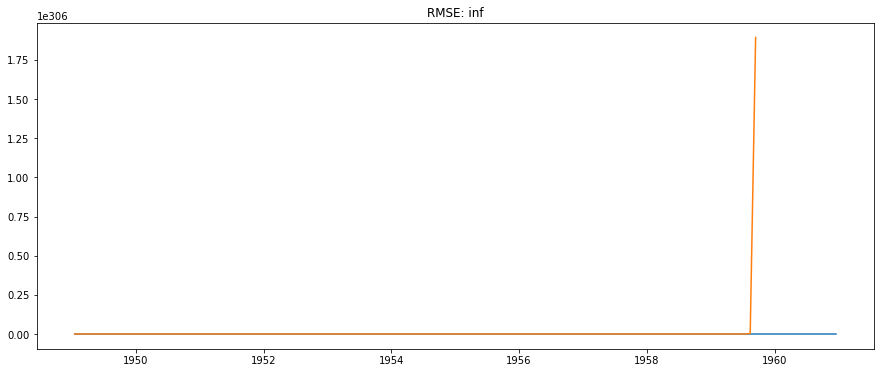

In [60]:
predict_Arima=np.exp(predict_ARIMA_log)
plt.plot(ts)
plt.plot(predict_Arima)
plt.title('RMSE: %.4f'% np.sqrt(sum((predict_Arima - ts)**2)/len(ts)))

In [86]:
from statsmodels.tsa.seasonal import  seasonal_decompose
decomposition = seasonal_decompose(predict_ARIMA_log,model='additive')

trend = decomposition.trend
Seasonal = decomposition.seasonal()
residual = decomposition.resid()

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None

In [84]:
ts_log.isna().sum()

0